In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
import time

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

import keras
import keras.backend as K
from sklearn.externals import joblib 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import xgboost as xgb

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


# Initial setup

In [2]:
startYear, endYear = 2004, 2006
years = range(startYear, endYear + 1)

In [3]:
# Location of US County shapefile used for creating the maps
shapefileFn = "simple-maps/examples/cb_2015_us_county_500k_clipped/cb_2015_us_county_500k_clipped.shp"
shapefileKey = "GEOID"

# Load data

### Migration data

In [4]:
migrationMatrices = [
    np.load("data/migration/usa_migrationMatrix_%d.npy" % (year))
    for year in years
]

for T in migrationMatrices:
    np.fill_diagonal(T, 0.0)

countyList = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    countyList.append(line)
f.close()
county_to_idx = {county:idx for idx, county in enumerate(countyList)}
numberOfCounties = len(countyList)

In [5]:
f = open("data/katrina_rita_training_counties.txt", "r")
floodedCounties = f.read().strip().split("\n")
f.close()


unfloodedCounties = [county for county in countyList if county not in floodedCounties]

floodedCounties = [county_to_idx[county] for county in floodedCounties]
unfloodedCounties = [county_to_idx[county] for county in unfloodedCounties]

### Per county features

In [6]:
df_medium = pd.read_csv("data/affected_population_medium.csv")
df_high = pd.read_csv("data/affected_population_high.csv")

In [7]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

medium_total_pop = [
    df_medium["Total Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_affected_pop = [
    df_medium["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_unaffected_pop = [
    medium_total_pop[i] - medium_affected_pop[i]
    for i in range(len(medium_years))
]

high_total_pop = [
    df_high["Total Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_affected_pop = [
    df_high["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_unaffected_pop = [
    high_total_pop[i] - high_affected_pop[i]
    for i in range(len(high_years))
]

In [8]:
df_high.head()

County FIPS  Total Population 2042  Affected Population 2042  \
0         1001           75026.083303                  0.000000   
1         1003          255284.070672               5236.769695   
2         1005           32916.391040                  0.000000   
3         1007           27928.724313                  0.000000   
4         1009           76781.224362                  0.000000   

   Total Population 2059  Affected Population 2059  Total Population 2071  \
0           85793.892861                   0.00000           93404.109103   
1          293115.199736               13735.94165          319819.526133   
2           35923.481033                   0.00000           38058.842373   
3           30607.910887                   0.00000           32505.428074   
4           87070.471455                   0.00000           94333.469402   

   Affected Population 2071  Total Population 2082  Affected Population 2082  \
0                  0.000000          100385.536214                  0.000000   
1              18918.263758          344298.491998              23262.786425   
2                  0.000000           40023.594705                  0.000000   
3                  0.000000           34248.485551                  0.000000   
4                  0.000000          100991.217521                  0.000000   

   Total Population 2091  Affected Population 2091  Total Population 2100  \
0          106100.843700                  0.000000          111818.665022   
1          364326.736796              26284.630257          384354.981594   
2           41635.534825                  0.000000           43250.924975   
3           35676.835878                  0.000000           37106.918684   
4          106438.465981                  0.000000          111885.714442   

   Affected Population 2100  Unnamed: 13  
0                  0.000000          NaN  
1              30432.478937          NaN  
2                  0.000000          NaN  
3                  0.000000          NaN  
4                  0.000000          NaN

### Extra features

In [9]:
distanceMatrix = np.load("data/migration/cb_2015_us_county_500k_distance_matrix.npy")

In [10]:
medium_intervening_unaffected_population = []
medium_intervening_total_population = []
for i in range(len(medium_years)):
    s = MigrationModels.getInterveningOpportunities(medium_unaffected_pop[i], distanceMatrix)
    medium_intervening_unaffected_population.append(s)
    
    s = MigrationModels.getInterveningOpportunities(medium_total_pop[i], distanceMatrix)
    medium_intervening_total_population.append(s)
    
high_intervening_unaffected_population = []
high_intervening_total_population = []
for i in range(len(high_years)):
    s = MigrationModels.getInterveningOpportunities(high_unaffected_pop[i], distanceMatrix)
    high_intervening_unaffected_population.append(s)
    
    s = MigrationModels.getInterveningOpportunities(high_total_pop[i], distanceMatrix)
    high_intervening_total_population.append(s)

# Evaluation Methods

In [11]:
def evaluateAll(Y_test, Y_pred, distanceMatrix):
    
    cpc  = EvaluationMethods.cpc(Y_test, Y_pred)
    cpcd = EvaluationMethods.cpc_d(Y_test, Y_pred, distanceMatrix)
    rmse = EvaluationMethods.rmse(Y_test, Y_pred)
    
    r2Score = r2_score(Y_test.flatten(), Y_pred.flatten())
    
    Y_test_incoming = Y_test.sum(axis=0)
    Y_pred_incoming = Y_pred.sum(axis=0)
    
    meanAbsoluteErrorIncoming = mean_absolute_error(Y_test_incoming, Y_pred_incoming)
    r2ScoreIncoming = r2_score(Y_test_incoming, Y_pred_incoming)
    rmseIncoming = np.sqrt(mean_squared_error(Y_test_incoming, Y_pred_incoming))

    return (cpc, cpcd, rmse, r2Score, meanAbsoluteErrorIncoming, r2ScoreIncoming)

# Format data

In [12]:
def loadAllPairs(population_origin, population_destination, D, S):
    
    numRows, numCols = population_origin.shape[0], population_destination.shape[0]
    assert D.shape[0] == numRows and D.shape[1] == numCols
    assert S.shape[0] == numRows and S.shape[1] == numCols
    
    numEntries = numRows * numCols
    numFeatures = 4
    
    X = np.zeros((numEntries, numFeatures), dtype=float)
    
    for i in xrange(numRows):
        for j in xrange(numCols):
            
            arrayIndex = (i*numCols) + j
            
            #origin_idx = origin_list[i]
            #dest_idx = destination_list[j]
            
            X[arrayIndex,:] = [
                population_origin[i],
                population_destination[j],
                D[i,j],
                S[i,j],
            ]
            
    return X

# Extended Radiation

### Medium results

In [13]:
medium_baseline_results = []

for i, year in enumerate(medium_years):
    population_origin = medium_total_pop[i]
    population_destination = medium_total_pop[i]
    s = medium_intervening_total_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)

    T  = MigrationModels.productionFunction(population_origin, P, beta=0.0357027324668133)
    
    medium_baseline_results.append(T)

In [14]:
medium_affected_results = []
medium_ablation_results = []
medium_affected_results_flooded = []
medium_affected_results_unflooded = []

for i, year in enumerate(medium_years):
    population_origin = medium_affected_pop[i]
    population_destination = medium_unaffected_pop[i]
    s = medium_intervening_unaffected_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.13)
    P = MigrationModels.row_normalize(P)
    T_affected  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)
    T_ablation  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    population_origin = medium_unaffected_pop[i]
    population_destination = medium_unaffected_pop[i]
    s = medium_intervening_unaffected_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)
    T_unaffected  = MigrationModels.productionFunction(population_origin, P, beta=0.03570273247)
    
    
    medium_affected_results.append(T_affected + T_unaffected)
    medium_ablation_results.append(T_ablation + T_unaffected)
    medium_affected_results_flooded.append(T_affected)
    medium_affected_results_unflooded.append(T_unaffected)

In [15]:
for i, year in enumerate(medium_years):
    print(year, np.sum(medium_affected_results[i]) - np.sum(medium_baseline_results[i]))

(2055, 1132555.8491151948)
(2080, 2205112.6158357784)
(2100, 3649862.5853493586)


### High results

In [16]:
high_baseline_results = []

for i, year in enumerate(high_years):
    population_origin = high_total_pop[i]
    population_destination = high_total_pop[i]
    s = high_intervening_total_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)

    T  = MigrationModels.productionFunction(population_origin, P, beta=0.0357027324668133)
    
    high_baseline_results.append(T)

In [17]:
high_affected_results = []
high_ablation_results = []
high_affected_results_flooded = []
high_affected_results_unflooded = []

for i, year in enumerate(high_years):
    population_origin = high_affected_pop[i]
    population_destination = high_unaffected_pop[i]
    s = high_intervening_unaffected_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.13)
    P = MigrationModels.row_normalize(P)
    T_affected  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)
    T_ablation  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    population_origin = high_unaffected_pop[i]
    population_destination = high_unaffected_pop[i]
    s = high_intervening_unaffected_population[i]
    
    P = MigrationModels.extendedRadiationModel(population_origin, population_destination, s, 0.33)
    P = MigrationModels.row_normalize(P)
    T_unaffected  = MigrationModels.productionFunction(population_origin, P, beta=0.03570273247)
    
    
    high_affected_results.append(T_affected + T_unaffected)
    high_ablation_results.append(T_ablation + T_unaffected)
    high_affected_results_flooded.append(T_affected)
    high_affected_results_unflooded.append(T_unaffected)

In [18]:
for i, year in enumerate(high_years):
    print(year, np.sum(high_affected_results[i]) - np.sum(high_baseline_results[i]))

(2042, 1015734.2290626038)
(2059, 1933026.9428994134)
(2071, 3123601.205287408)
(2082, 4860246.126232408)
(2091, 7629351.138777524)
(2100, 11829991.356151406)


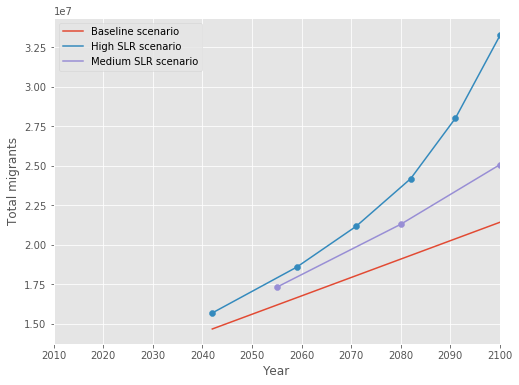

In [19]:
plt.figure(figsize=(8,6))

plt.plot(high_years, [t.sum() for t in high_baseline_results], label="Baseline scenario")
#plt.scatter(high_years, [t.sum() for t in high_baseline_results])
plt.scatter([],[])

plt.plot(high_years, [t.sum() for t in high_affected_results], label="High SLR scenario")
plt.scatter(high_years, [t.sum() for t in high_affected_results])


plt.plot(medium_years, [t.sum() for t in medium_affected_results], label="Medium SLR scenario")
plt.scatter(medium_years, [t.sum() for t in medium_affected_results])
plt.legend(loc="best")

plt.xlim([2010,2100])

plt.xlabel("Year")
plt.ylabel("Total migrants")

plt.show()
plt.close()

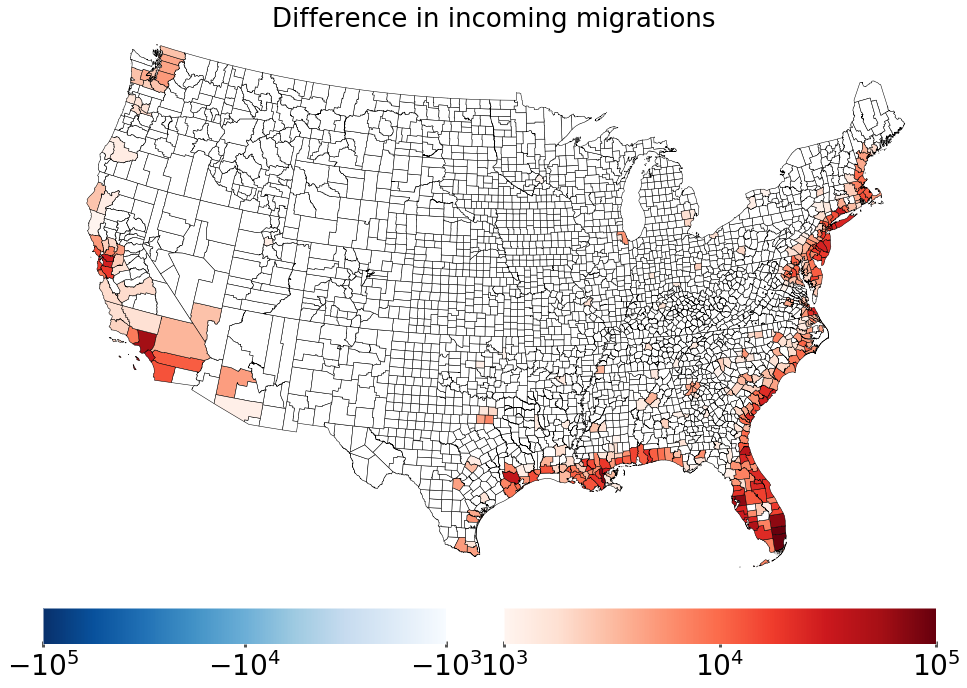

In [67]:
t_affected_incoming =  medium_affected_results[-1].sum(axis=0)
t_baseline_incoming =  medium_baseline_results[-1].sum(axis=0)
map_data = {
    county: t_affected_incoming[i] - t_baseline_incoming[i]
    for i, county in enumerate(countyList)
}

differenceMap(
    shapefileFn,
    shapefileKey,
    map_data,
    #outputFn="examples/demoSimpleFigureNormal.png",
    bounds=[22, 49, -119, -64],
    title="Difference in incoming migrations",
    colorbarRange=(1e3, 1e5),
    logScale=True,
)

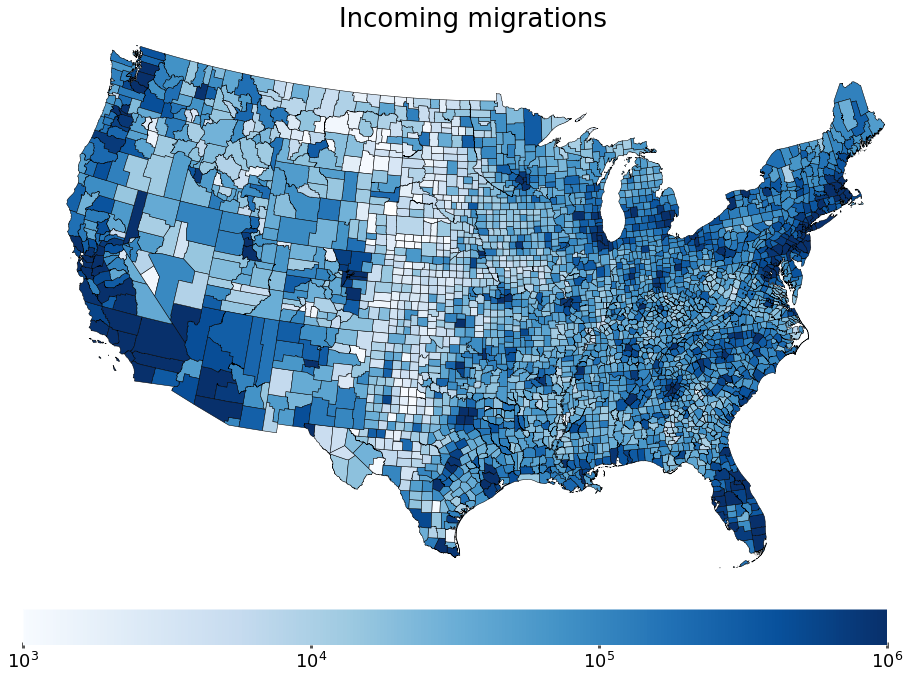

In [63]:
t_baseline_incoming =  high_baseline_results[-1].sum(axis=0)
map_data = {
    county: high_total_pop[-1][i,0]
    for i, county in enumerate(countyList)
}

simpleMap(
    shapefileFn,
    shapefileKey,
    map_data,
    #outputFn="examples/demoSimpleFigureNormal.png",
    bounds=[22, 49, -119, -64],
    title="Incoming migrations",
    colorbarRange=(1e3, 1e6),
    logScale=True,
)

### Save results

In [20]:
for i, year in enumerate(medium_years):
    np.save("output/extrad_medium_baseline_results_%d.npy" % (year), medium_baseline_results[i])
    np.save("output/extrad_medium_affected_results_%d.npy" % (year), medium_affected_results[i])
    np.save("output/extrad_medium_ablation_results_%d.npy" % (year), medium_ablation_results[i])
    
    np.save("output/extrad_medium_affected_results_flooded_%d.npy" % (year), medium_affected_results_flooded[i])
    np.save("output/extrad_medium_affected_results_unflooded_%d.npy" % (year), medium_affected_results_unflooded[i])
    
for i, year in enumerate(high_years):
    np.save("output/extrad_high_baseline_results_%d.npy" % (year), high_baseline_results[i])
    np.save("output/extrad_high_affected_results_%d.npy" % (year), high_affected_results[i])
    np.save("output/extrad_high_ablation_results_%d.npy" % (year), high_ablation_results[i])
    
    np.save("output/extrad_high_affected_results_flooded_%d.npy" % (year), high_affected_results_flooded[i])
    np.save("output/extrad_high_affected_results_unflooded_%d.npy" % (year), high_affected_results_unflooded[i])

# Machine learning models

### Medium results

In [20]:
%%time
medium_baseline_results = []

scaler_flooded = joblib.load("output/scaler_flooded.p")
scaler_unflooded = joblib.load("output/scaler_unflooded.p")

#model_flooded = xgb.XGBRegressor(n_jobs=16)
#model_flooded.load_model("output/xgboost_flooded.p")
#model_unflooded = xgb.XGBRegressor(n_jobs=16)
#model_unflooded.load_model("output/xgboost_unflooded.p")

model_flooded = keras.models.load_model("output/dl_flooded.p", custom_objects={"cpcLoss":"mse"})
model_unflooded = keras.models.load_model("output/dl_unflooded.p", custom_objects={"cpcLoss":"mse"})


for i, year in enumerate(medium_years):
    print(year)
    population_origin = medium_total_pop[i]
    population_destination = medium_total_pop[i]
    s = medium_intervening_total_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T  = MigrationModels.productionFunction(population_origin, P, beta=0.0357027324668133)
    
    medium_baseline_results.append(T)

2055


/home/caleb/Dropbox/code/migration_slr/migration-lib/MigrationModels.py:32: RuntimeWarning: invalid value encountered in divide
  return P / P.sum(axis=1, keepdims=True)


2080
2100
CPU times: user 3min 51s, sys: 25.2 s, total: 4min 16s
Wall time: 1min 3s


In [21]:
%%time
medium_affected_results = []
medium_ablation_results = []

medium_affected_results_flooded = []
medium_affected_results_unflooded = []

for i, year in enumerate(medium_years):
    print(year)
    
    # Use the affected model for affected to unaffected
    population_origin = medium_affected_pop[i]
    population_destination = medium_unaffected_pop[i]
    s = medium_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_flooded.transform(X_pred)
    P = model_flooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_affected  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    # Use the unaffected model for unaffected to unaffected
    population_origin = medium_unaffected_pop[i]
    population_destination = medium_unaffected_pop[i]
    s = medium_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_unaffected  = MigrationModels.productionFunction(population_origin, P, beta=0.03570273247)
    
    
    # Use the unaffected model for affected to unaffected
    population_origin = medium_affected_pop[i]
    population_destination = medium_unaffected_pop[i]
    s = medium_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_ablation  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    medium_affected_results.append(T_affected + T_unaffected)
    medium_ablation_results.append(T_ablation + T_unaffected)
    
    medium_affected_results_flooded.append(T_affected)
    medium_affected_results_unflooded.append(T_unaffected)
    #np.save("output/dl_medium_slr_affected_results_%d.npy" % (year), T_affected)
    #np.save("output/dl_medium_slr_unaffected_results_%d.npy" % (year), T_unaffected)

2055
2080
2100
CPU times: user 10min 7s, sys: 1min 12s, total: 11min 19s
Wall time: 2min 57s


### High results

In [22]:
%%time
high_baseline_results = []

for i, year in enumerate(high_years):
    print(year)
    population_origin = high_total_pop[i]
    population_destination = high_total_pop[i]
    s = high_intervening_total_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T  = MigrationModels.productionFunction(population_origin, P, beta=0.0357027324668133)
    
    high_baseline_results.append(T)
    
    #np.save("output/dl_high_slr_baseline_results_%d.npy" % (year), T)

2042
2059
2071
2082
2091
2100
CPU times: user 7min 43s, sys: 55.1 s, total: 8min 38s
Wall time: 2min 3s


In [23]:
%%time
high_affected_results = []
high_ablation_results = []

high_affected_results_flooded = []
high_affected_results_unflooded = []

for i, year in enumerate(high_years):
    print(year)
    
    # Use the affected model for affected to unaffected
    population_origin = high_affected_pop[i]
    population_destination = high_unaffected_pop[i]
    s = high_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_flooded.transform(X_pred)
    P = model_flooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_affected  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    # Use the unaffected model for unaffected to unaffected
    population_origin = high_unaffected_pop[i]
    population_destination = high_unaffected_pop[i]
    s = high_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_unaffected  = MigrationModels.productionFunction(population_origin, P, beta=0.03570273247)
    
    
    # Use the unaffected model for affected to unaffected
    population_origin = high_affected_pop[i]
    population_destination = high_unaffected_pop[i]
    s = high_intervening_unaffected_population[i]
    
    X_pred = loadAllPairs(population_origin, population_destination, distanceMatrix, s)
    X_pred = scaler_unflooded.transform(X_pred)
    P = model_unflooded.predict(X_pred, batch_size=2**14, verbose=0)
    P = P.reshape(numberOfCounties, numberOfCounties)
    P = MigrationModels.row_normalize(P)
    P[np.isnan(P) | np.isinf(P)] = 0
    T_ablation  = MigrationModels.productionFunction(population_origin, P, beta=1.0)
    
    
    high_affected_results.append(T_affected + T_unaffected)
    high_ablation_results.append(T_ablation + T_unaffected)
    
    high_affected_results_flooded.append(T_affected)
    high_affected_results_unflooded.append(T_unaffected)
    #np.save("output/dl_high_slr_affected_results_%d.npy" % (year), T_affected)
    #np.save("output/dl_high_slr_unaffected_results_%d.npy" % (year), T_unaffected)

2042
2059
2071
2082
2091
2100
CPU times: user 20min 11s, sys: 2min 24s, total: 22min 35s
Wall time: 5min 48s


## Make sure it works

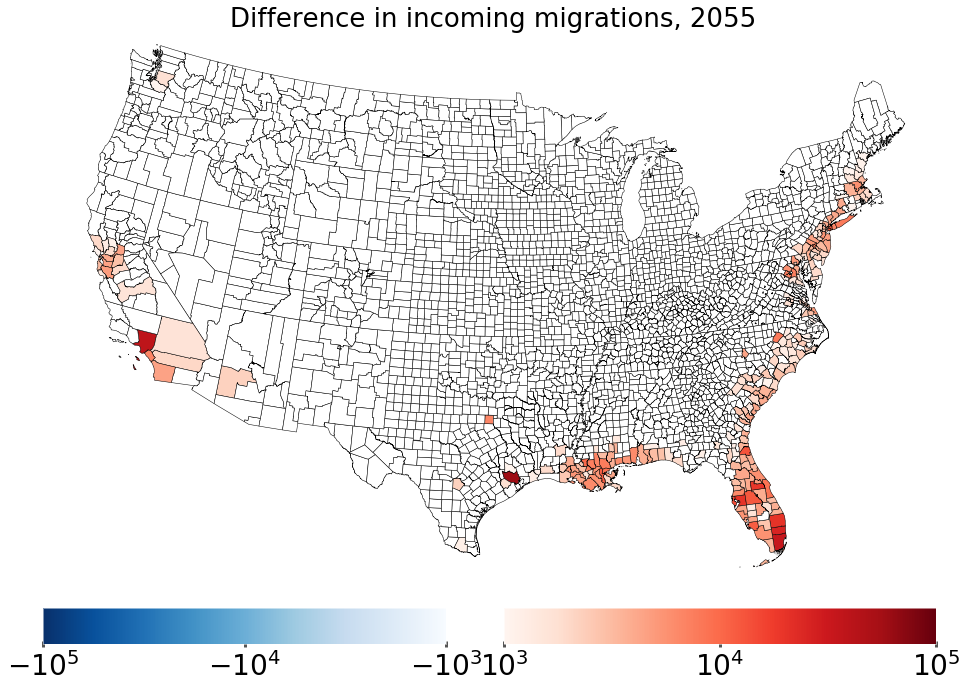

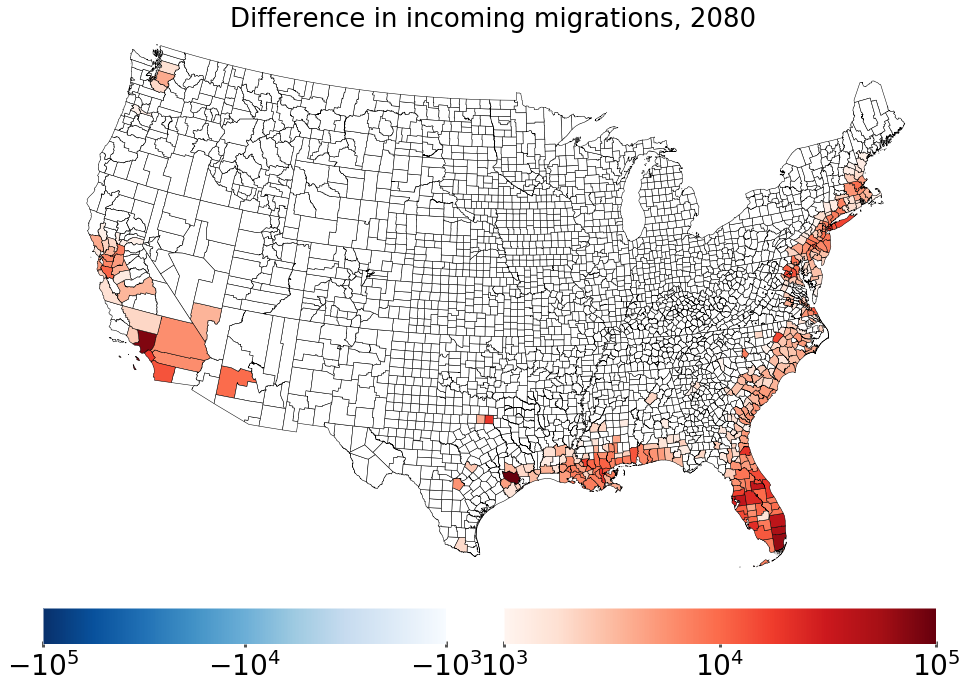

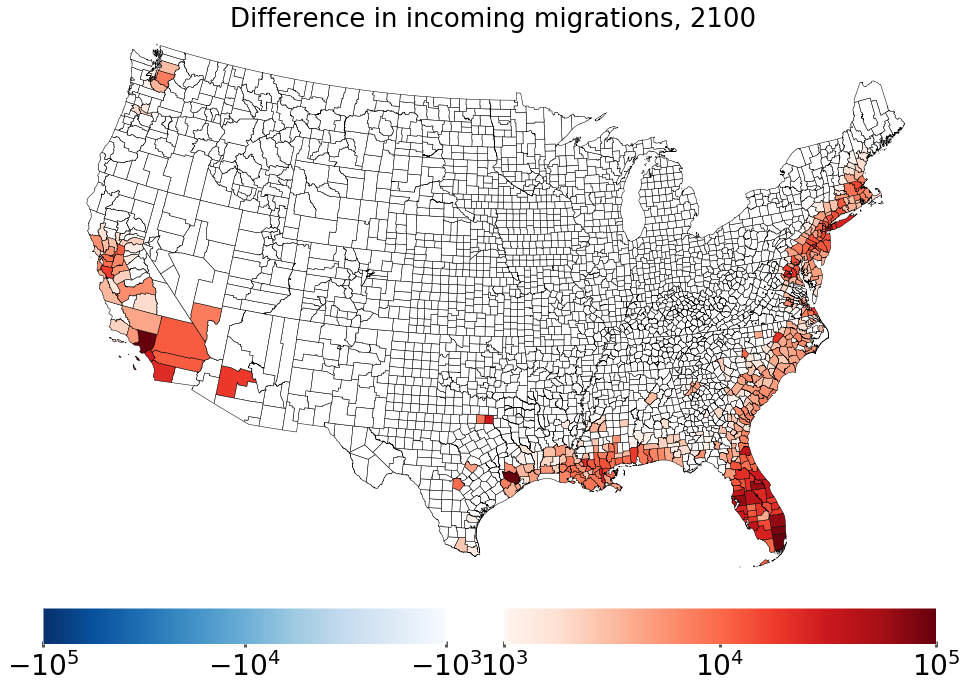

In [104]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_results[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_results[i].sum(axis=0)
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        #outputFn="examples/demoSimpleFigureNormal.png",
        bounds=[22, 49, -119, -64],
        title="Difference in incoming migrations, %d" % (year),
        colorbarRange=(1e3, 1e5),
        logScale=True,
    )

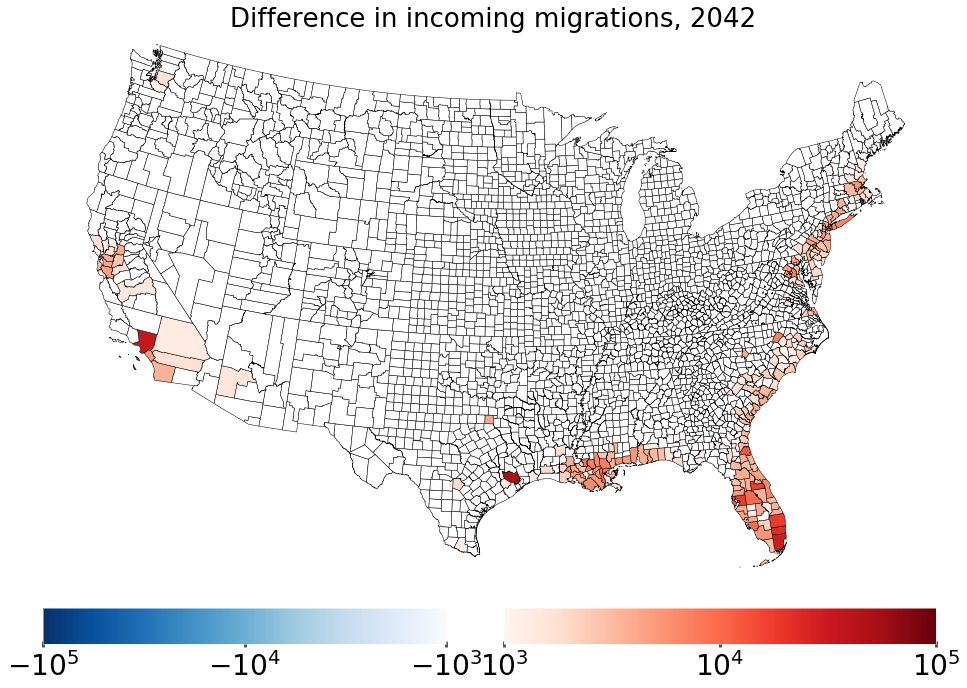

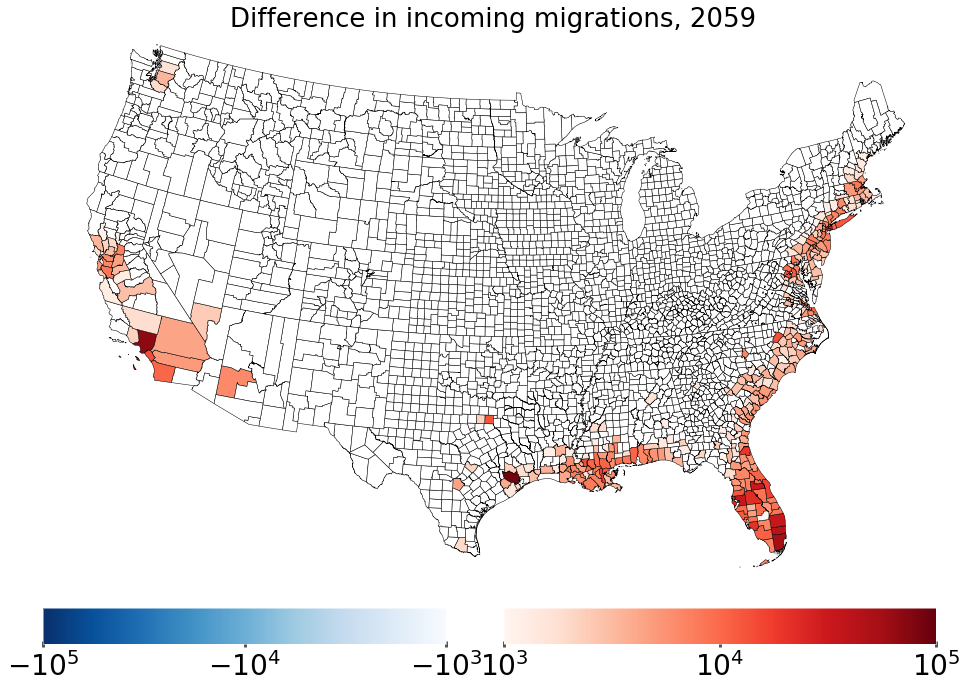

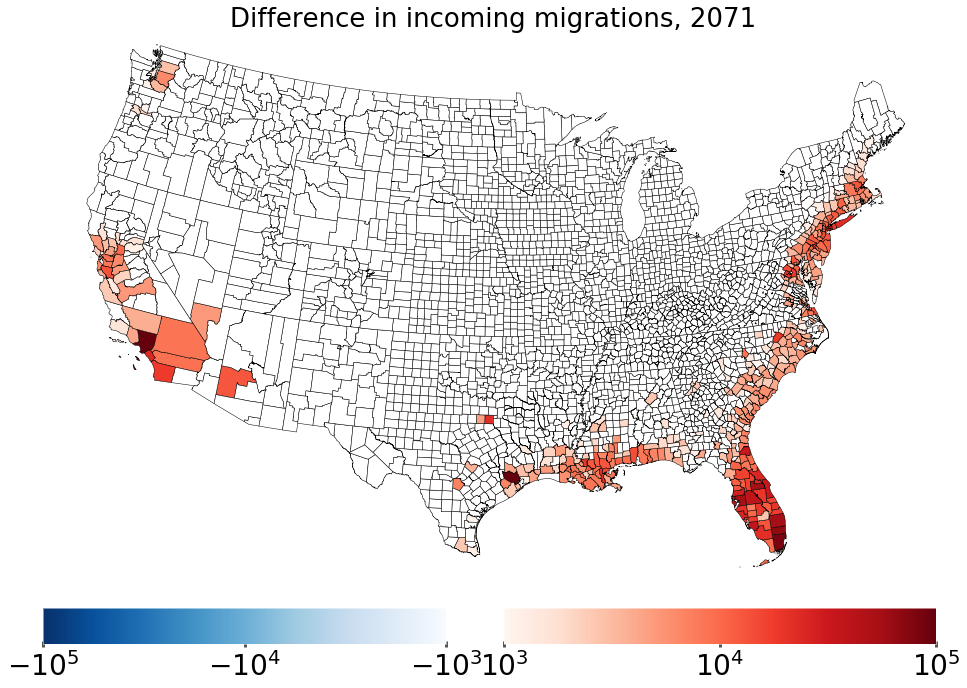

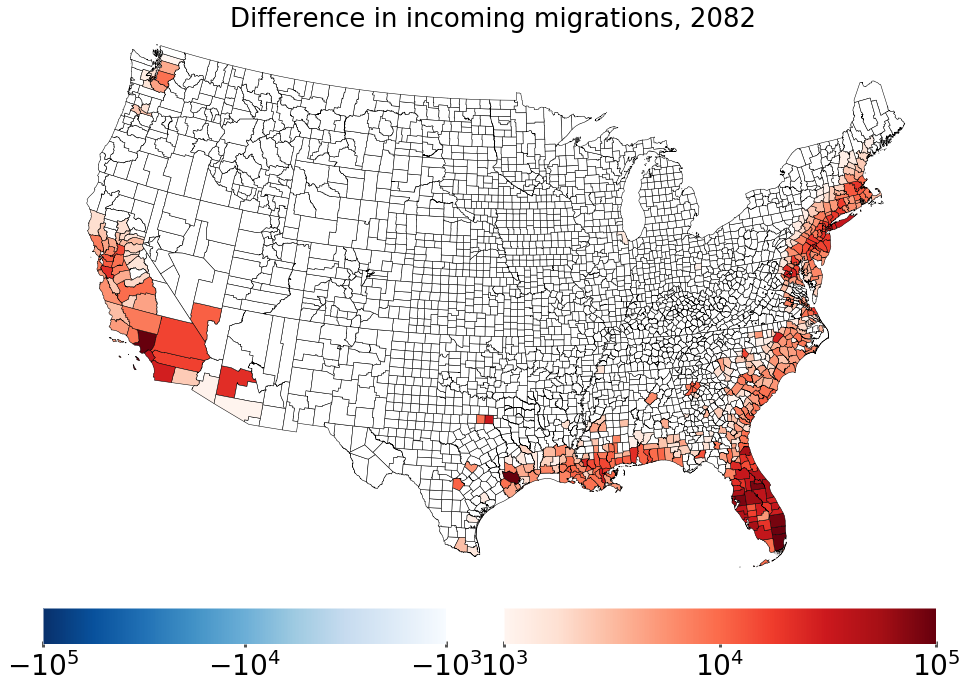

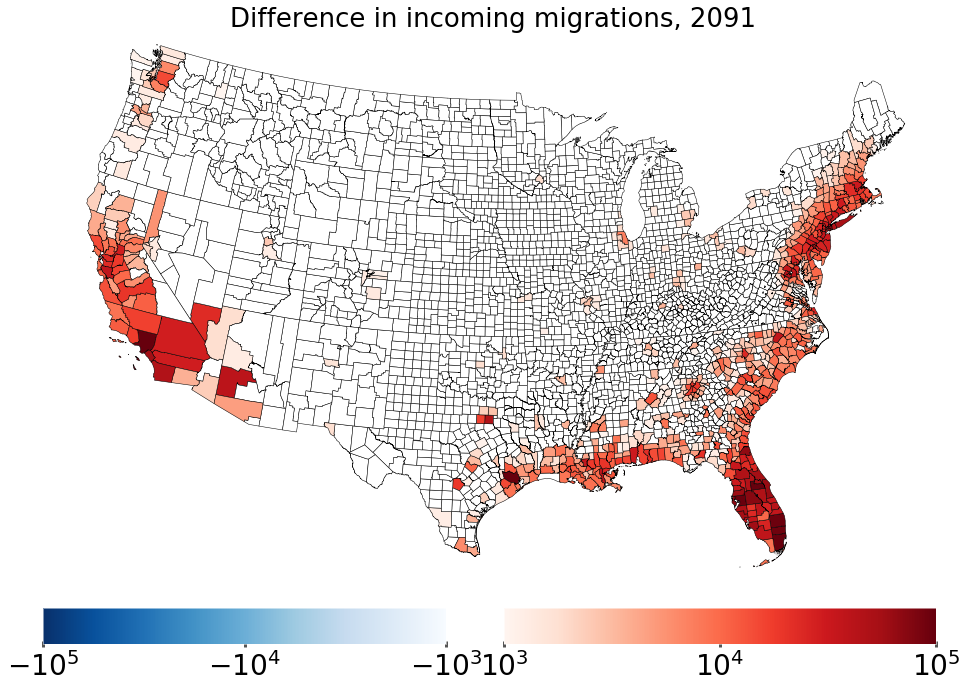

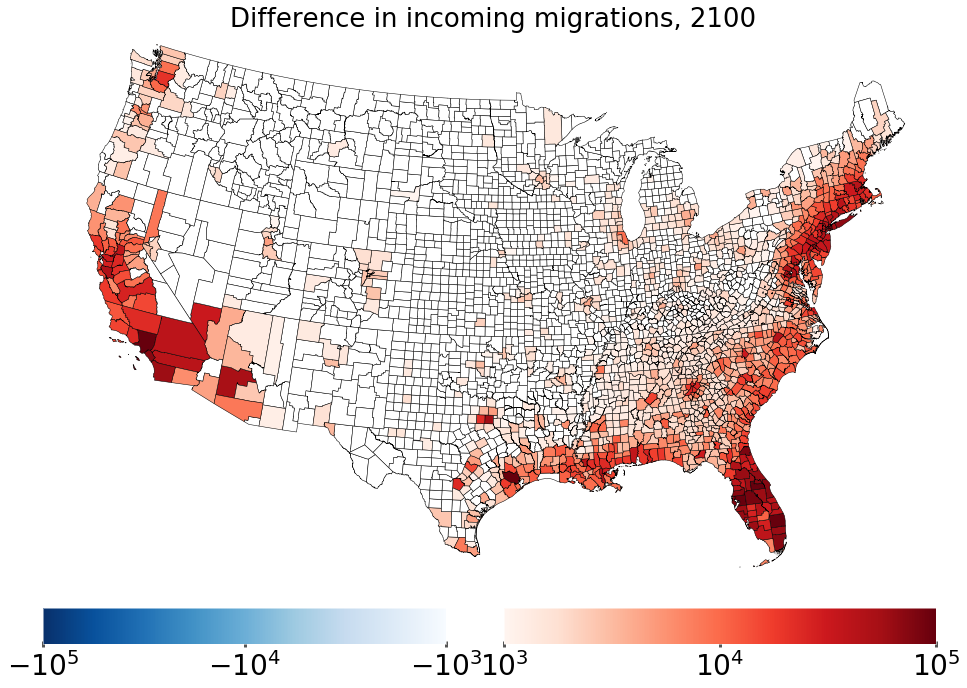

In [107]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_results[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_results[i].sum(axis=0)
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        #outputFn="examples/demoSimpleFigureNormal.png",
        bounds=[22, 49, -119, -64],
        title="Difference in incoming migrations, %d" % (year),
        colorbarRange=(1e3, 1e5),
        logScale=True,
    )

In [ ]:
for i, year in enumerate(medium_years):
    np.save("output/dl_medium_baseline_results_%d.npy" % (year), medium_baseline_results[i])
    np.save("output/dl_medium_affected_results_%d.npy" % (year), medium_affected_results[i])
    np.save("output/dl_medium_ablation_results_%d.npy" % (year), medium_ablation_results[i])
    
    np.save("output/dl_medium_affected_results_flooded_%d.npy" % (year), medium_affected_results_flooded[i])
    np.save("output/dl_medium_affected_results_unflooded_%d.npy" % (year), medium_affected_results_unflooded[i])
for i, year in enumerate(high_years):
    np.save("output/dl_high_baseline_results_%d.npy" % (year), high_baseline_results[i])
    np.save("output/dl_high_affected_results_%d.npy" % (year), high_affected_results[i])
    np.save("output/dl_high_ablation_results_%d.npy" % (year), high_ablation_results[i])
    
    np.save("output/dl_high_affected_results_flooded_%d.npy" % (year), high_affected_results_flooded[i])
    np.save("output/dl_high_affected_results_unflooded_%d.npy" % (year), high_affected_results_unflooded[i])